In [previous](/posts/gaussian_dispersion_example/) [examples](/posts/building_infiltration_eg2/) I used both Gaussian plume and puff models for continuous and instantaneous releases, respectively, but what about the in-between cases? It is more commonly the case for a leak from a process vessel to be a prolonged, but finitely long, release.

The guidance is to typically pick one or the other, depending upon the length of the release, or use a more complex model, e.g. the guidance in Lees[@lees-1996 page 15/199] is

|                                               |                                    |
|:---------------------------------------------:|:-----------------------------------|
| $$ u \Delta t \lt 2 \sigma_x $$               | Use puff model                     |
| $$ 2 \sigma_x \lt u \Delta t \lt 5 \sigma_x$$ | Neither model entirely appropriate |
| $$ u \Delta t \gt 5 \sigma_x $$               | Use plume model                    |


Where *u* is the wind speed, *&Delta;t* the duration of the release, and $\sigma_x$ is the downwind dispersion evaluated at $x = \frac{u \Delta t}{2}$.[^criteria]

[^criteria]: These criteria drive one to using a plume model in most cases that are not *"instantaneous"*. Suppose $\sigma_x = \alpha x^\beta$ then the criteria for a puff is $u \Delta t \lt 2 \alpha^{1 \over 1-\beta}$ which, for a class D release with windspeed of 2m/s works out to $\Delta t \lt 5 \times  10^{-16} \mathrm{s}$. The criteria for a plume is $u \Delta t \gt 2 \left( 2.5 \alpha \right)^{1 \over 1-\beta}$ which works out to $\Delta t \gt 5 \times  10^{-11} \mathrm{s}$ for the same situation. So for any release of appreciable duration it will be a plume.</span>

An alternative approach is to evaluate the downwind dispersion at a particular point of interest *x<sub>1</sub>* and use the same criteria. This is much less strict than what *Lees* gives and is what I will do, it motivates investigating anything other than pure plume models.

One approach in this in-between zone is to try both and pick the most conservative. But that can lead to extremely conservative results. An alternative might be to take a page from more complex models, such as [INTPUFF](https://cfpub.epa.gov/si/si_public_record_Report.cfm?Lab=ORD&dirEntryId=47242) and [SCIPUFF](http://www.scipuff.org/about/), and treat an intermediate release as a series of smaller puff releases.


## Motivating example

Suppose a release from a process vessel, say a jet of gas issuing from a hole, we suppose the release is a constant rate of *1kg/s* for *5s* just for some nice round numbers. The release is at ground level and the ambient conditions are class D with a *2m/s* windspeed. We have a point of interest *100m* down-wind of the release, this could be an inhabited building or the fence-line.[^buoyancy]

[^buoyancy]: We are also implicitly assuming the release is neutrally buoyant, and so a Gaussian dispersion model would be appropriate.

In [1]:
#| output: false
m  = 1 #kg/s
Δt = 5 #s
h  = 0 #m
u  = 2 #m/s

x₁ = 100  #m
t₁ = x₁/u #s

50.0

The class D dispersion parameters[@ccps-1999 page 90] are:

In [2]:
#| output: false
# class D puff dispersion

σx(x) = 0.06*x^0.92
σy(x) = σx(x)
σz(x) = 0.15*x^0.70

σz (generic function with 1 method)

The release, at the point of interest, meets neither the criteria for a puff model nor a plume model.

In [3]:
u*Δt < 2*σx(x₁)

false

In [4]:
u*Δt > 5*σx(x₁)

false

So some other kind of model must be used.

## Single Gaussian puff

Recall that a single Gaussian puff is the product of 3 Gaussian distributions

$$ c \left(x,y,z,t \right) = m \Delta t \cdot g_x(x, t) \cdot g_y(y) \cdot g_z(z) $$

with

$$ g_x(x,t) = {1 \over \sqrt{2\pi} \sigma_x } \exp \left( -\frac{1}{2} \left( x-u t \over \sigma_x \right)^2 \right) $$

$$ g_y(y) = {1 \over \sqrt{2\pi} \sigma_y } \exp \left( -\frac{1}{2} \left( y \over \sigma_y \right)^2 \right) $$

$$ g_z(z) = {1 \over \sqrt{2\pi} \sigma_z } \left[ \exp \left( -\frac{1}{2} \left( z-h \over \sigma_z \right)^2 \right) + \exp \left( -\frac{1}{2} \left( z+h \over \sigma_z \right)^2 \right) \right]$$

where, for the sake of clarity, I've neglected the fact that the dispersion parameters &sigma; are themselves all functions of *t* by being functions of the location of the center of the puff.

In [5]:
#| output: false
gx(x, t) = exp((-1/2)*((x-u*t)/σx(u*t))^2)/(√(2π)*σx(u*t))
gy(y, t) = exp((-1/2)*(y/σy(u*t))^2)/(√(2π)*σy(u*t))
gz(z, t) = (exp((-1/2)*((z-h)/σz(u*t))^2)+exp((-1/2)*((z+h)/σz(u*t))^2))/(√(2π)*σz(u*t))

gz (generic function with 1 method)

In [6]:
#| output: false
c_pf(x,y,z,t; m, Δt) = m*Δt*gx(x,t)*gy(y,t)*gz(z,t)

c_pf (generic function with 1 method)

For some context we can plot the puff as a single, instantaneous, release

points not sorted in ascending order
[ Info: Saved animation to /home/allan/Code/notes/notebooks/tmp.gif


Plots.AnimatedGif("/home/allan/Code/notes/notebooks/tmp.gif")
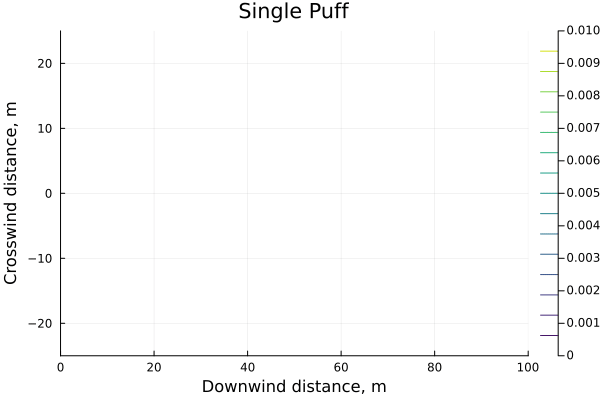

In [7]:
#| echo: false
#| warning: false
#| label: fig-single-puff
#| fig-cap: "The dispersion of a single, instantaneous, puff."

using Plots
    
@gif for t in range(0,t₁, length=50)
    α = 4.3
    xₜ = u*t
    xs = range(xₜ-α*σx(xₜ), xₜ+α*σx(xₜ), length=100)
    ys = range(-α*σy(xₜ), α*σy(xₜ), length=100)

    plot(xs, ys, (x,y)->c_pf(x,y,h,t; m=m, Δt=Δt), seriestype=:contour,
        c=:viridis, fill=false, clim=(0,0.01), 
        xlim=(0,x₁), ylim=(-x₁/4,x₁/4),
        xlabel="Downwind distance, m", ylabel="Crosswind distance, m",
        title="Single Puff")
end

## Multiple puffs

Our first approximation to a release of appreciable duration is to break the release up into *n* intervals and release a single puff per interval.

$$ c(x,y,z,t) = \sum_{i=0}^{n}  m \frac{\Delta t}{n} \cdot g_x(x, t-\frac{i}{n}\Delta t) \cdot g_y(y) \cdot g_z(z) $$

where we have simply taken the sum of *n* single puffs, each representing a fraction of the overall release, and emitting them one after the other.

In [8]:
#| output: false
function sum_of_puffs(x,y,z,t; m, Δt, n)
    c = 0
    δt = Δt/n
    for i in 0:1:n
        t′ = t-i*δt
        c′  = t′>0 ? c_pf(x,y,z,t′; m=m, Δt=δt) : 0
        c += isnan(c′) ? 0 : c′ 
    end
    return c
end

sum_of_puffs (generic function with 1 method)

We can plot this for *n=5* and we see that, while initially the individual puffs are distinct, they quickly merge into a larger more spread-out cloud.[^stability]

[^stability]: To an extent this is a function of using a class D atmosphere. For a much more stable atmosphere, e.g. class F, the puffs remain quite distinct until a size-able number of them have been released.

points not sorted in ascending order
[ Info: Saved animation to /home/allan/Code/notes/notebooks/tmp.gif


Plots.AnimatedGif("/home/allan/Code/notes/notebooks/tmp.gif")
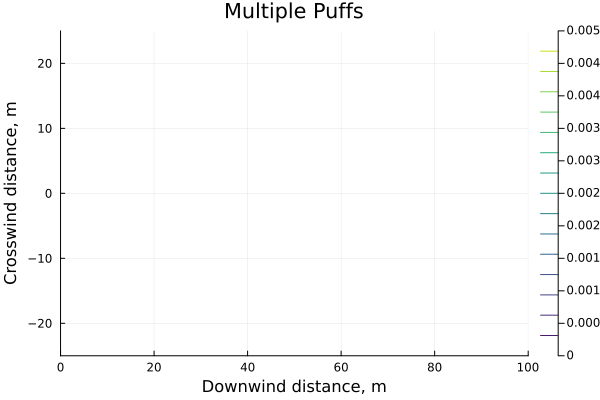

In [9]:
#| echo: false
#| warning: false
#| label: fig-multiple-puffs
#| fig-cap: "The dispersion of a sequence of multiple smaller puffs."

@gif for t in range(0,t₁, length=50)
    α = 4.3
    xₜ = u*t
    xs = range(max(xₜ-u*Δt-α*σx(xₜ),0), xₜ+α*σx(xₜ), length=100)
    ys = range(-α*σy(xₜ), α*σy(xₜ), length=100)

    plot(xs, ys, (x,y)->sum_of_puffs(x,y,h,t; m=m, Δt=Δt, n=5), seriestype=:contour,
        c=:viridis, fill=false, clim=(0,0.005), 
        xlim=(0,x₁), ylim=(-x₁/4, x₁/4),
        xlabel="Downwind distance, m", ylabel="Crosswind distance, m",
        title="Multiple Puffs")
end

If we plot the max-concentration experienced at our point of interest, *x=100m*, against an increasingly finely-divided release (more puffs, but each puff represents a smaller slice of time) it is clear that they are converging towards a number, and relatively quickly.

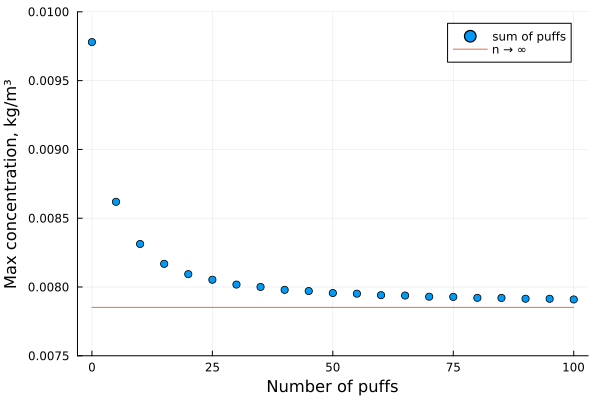

In [10]:
#| echo: false
#| label: fig-n-puffs
#| fig-cap: "The effect of increasing the number of puffs"

let

ns = collect(0:5:100)
cs = [ n≥5 ? sum_of_puffs(x₁,0,h,t₁+floor(n/2)*(Δt/n); m=m, Δt=Δt, n=n) :  c_pf(x₁,0,h,t₁; m=m, Δt=Δt) for n in ns ]
c∞ = 0.00785197815961751
    
plot(ns, cs, lab="sum of puffs", seriestype=:scatter)
plot!([0; 100], [c∞; c∞], lab="n → ∞")
plot!(ylim=(0.0075,0.01), xlabel="Number of puffs", ylabel="Max concentration, kg/m³")
 
end

This suggests a next step, taking the limit as $n \to \infty$

## Integrated puffs

Returning to our model of multiple puffs

$$ c(x,y,z,t) = \sum_{i=0}^{n}  m \frac{\Delta t}{n} \cdot g_x(x, t-\frac{i}{n}\Delta t) \cdot g_y(y) \cdot g_z(z) $$

We can re-arrange this and take the limit as $n \to \infty$

$$ c(x,y,z,t) = m\cdot g_y(y) \cdot g_z(z) \cdot \left( \lim_{n \to \infty} \sum_{i=0}^{n} g_x(x, t-\frac{i}{n}\Delta t) \frac{\Delta t}{n} \right) $$

$$ = m\cdot g_y(y) \cdot g_z(z) \cdot \int_{t-\Delta t}^{t} g_x(x, t^{\prime}) dt^{\prime}$$

Where we have replaced the limit with the integral.[^disp-constants]

[^disp-constants]: I am assuming the dispersion parameters are constants, though they are not in practice as they are correlated to the downwind distance to the center of any given puff. I am assuming for a small enough release this is approximately constant at least.

This is an integral of a Gaussian, and so we expect the results to be in terms of the [error function](https://en.wikipedia.org/wiki/Error_function)

$$ \mathrm{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x \exp \left( -t^2 \right) dt $$

For the integral of the *x component* of the Gaussian puff we have

$$ \int_{t-\Delta t}^{t} g_x(x, t^{\prime}) dt^{\prime} = \int_{t-\Delta t}^{t} {1 \over \sqrt{2\pi} \sigma_x } \exp \left( -\frac{1}{2} \left( x-u t^{\prime} \over \sigma_x \right)^2 \right) dt^{\prime}$$

making the substitution $$\xi = { {x - u t^{\prime} } \over \sqrt{2} \sigma_x} $$

we get[^time]

$$ \int_{t-\Delta t}^{t} g_x(x, t^{\prime}) dt^{\prime} = {-1 \over \sqrt{\pi} u} \int_{a}^{b} \exp \left( -\xi^2 \right) d\xi $$

$$ = {-1 \over \sqrt{\pi} u} \left[ \frac{\sqrt{\pi}}{2} \mathrm{erf}(b) - \frac{\sqrt{\pi}}{2} \mathrm{erf}(a) \right] $$

$$ = \frac{1}{2u} \left( \mathrm{erf}(a) - \mathrm{erf}(b) \right)$$

where 

$$a = { {x - u (t-\Delta t)} \over \sqrt{2} \sigma_x }$$

$$b = { {x - u t} \over \sqrt{2} \sigma_x } $$

[^time]: This model and the sum of puffs model both naively include contributions from releases that haven't happened yet, e.g. at t=1 only the contribution of material released at times t&le;1 should be included, but without any correction the other parts of the release would be included causing slight errors in the vicinity of the release point at t&lt;&Delta;t. The solution is simply to take the duration of the release to be the minimum of either the elapsed time (i.e. when the release is still "happening") or the total release duration.

In [11]:
#| output: false
using SpecialFunctions: erf

function ∫gx(x,t,Δt)
    Δt = min(t,Δt)
    a  = (x-u*(t-Δt))/(√2*σx(u*(t-Δt)))
    b  = (x-u*t)/(√2*σx(u*t))
    return erf(b,a)/(2u)
end

intpuff(x,y,z,t; m, Δt) = m*gy(y,x/u)*gz(z,x/u)*∫gx(x,t,Δt)

intpuff (generic function with 1 method)

points not sorted in ascending order
[ Info: Saved animation to /home/allan/Code/notes/notebooks/tmp.gif


Plots.AnimatedGif("/home/allan/Code/notes/notebooks/tmp.gif")
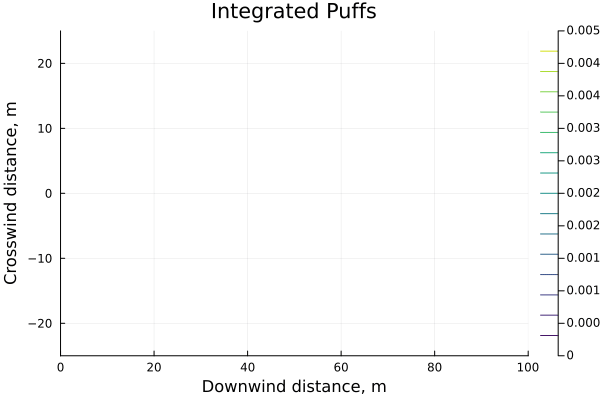

In [12]:
#| echo: false
#| warning: false
#| label: fig-int-puffs
#| fig-cap: "The dispersion of the integrated puff model, assuming constant dispersion/"

@gif for t in range(0,t₁, length=50)
    α  = 4.3
    xₜ = u*t
    xs = range(max(xₜ-u*Δt-α*σx(xₜ),0), xₜ+α*σx(xₜ), length=100)
    ys = range(-α*σy(xₜ), α*σy(xₜ), length=100)

    plot(xs, ys, (x,y)->intpuff(x,y,h,t; m=m, Δt=Δt), seriestype=:contour,
        c=:viridis, fill=false, clim=(0,0.005), 
        xlim=(0,x₁), ylim=(-x₁/4, x₁/4),
        xlabel="Downwind distance, m", ylabel="Crosswind distance, m",
        title="Integrated Puffs")
end

This release model has some convenient properties: clearly as $\Delta t \to 0$ it becomes a Gaussian puff again, but also as $\Delta t \to \infty$ also limits to the Gaussian plume.[^limits]

[^limits]:This is somewhat hand-wavy but a release of infinite duration is an event that began an infinite amount of time in the past and continues an infinite amount into the future, so the term $\frac{1}{2u} \left( \mathrm{erf}(a) - \mathrm{erf}(b) \right)$ goes in the limit to $\frac{1}{2u} \left( \mathrm{erf}(\infty) - \mathrm{erf}(-\infty) \right) = \frac{1}{u}$ resulting in a concentration profile of $c \left(x,y,z,t \right) = \frac{m}{u} \cdot g_y(y) \cdot g_z(z)$, which is exactly a plume model.</span>

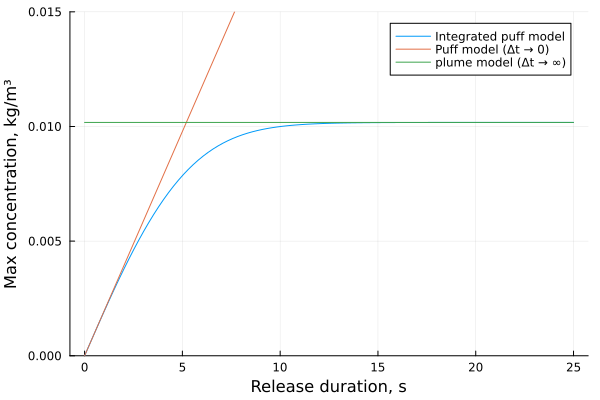

In [13]:
#| echo: false
#| label: fig-int-limiting
#| fig-cap: "The limiting behaviour of the integrated puff model, it smoothly connects the single puff model and the plume model when using the same dispersion constants."

let

cₚₗ= (m/u)*gy(0,t₁)*gz(0,t₁)
Δts  = collect(range(0,25; length=100))
cs   = [ intpuff(x₁,0,h,t₁+0.5*Δt′; m=m, Δt=Δt′) for Δt′ in Δts ]
cpfs = [ c_pf(x₁,0,h,t₁; m=m, Δt=Δt′) for Δt′ in Δts]

plot(Δts, cs, lab="Integrated puff model")
plot!(Δts, cpfs, lab="Puff model (Δt → 0)")
plot!([0; 25], [cₚₗ; cₚₗ], lab="plume model (Δt → ∞)")
plot!(ylim=(0,0.015),xlabel="Release duration, s", ylabel="Max concentration, kg/m³")
 
end

## Complications

I've been casually treating the dispersion parameters, $\sigma_x, \sigma_y, \sigma_z$, as being constants that are independent of the model and any transformations on the model. Within the context of taking sums and doing integrals it is reasonable: within a reasonable radius of the center of a given puff they are nearly constant. However, in practice, they depend upon time through their dependence on the location of the puff center and are also functions of the model itself.

The dispersion parameters for a plume model are not the same as for a puff, and so the nice smooth curve connecting the two doesn't really work. Not if you are strictly taking dispersion parameters as provided in standard references. It is not at all clear how to transition from the one set to the other either, in a smooth manner, to ensure that there is a smooth transition from puff to plume.

That said, multiple puff models use the dispersion parameters for puffs and so using the puff parameters in the integrated puff model at least puts one in good company.

::: {.callout-warning}
## Update

There is [a follow-up post](/posts/intpuff2_successive_approximations/) that discusses the quality of these approximations in more detail.

When I first wrote this post I could not find my final result in the literature -- it wasn't in the standard references I use, and I think I just didn't know the right search terms. Though it seemed equally obvious to me that it *must* be in the literature somewhere. Since posting this, I found it: @palazzi-1982. This is also the model used by [ALOHA](https://response.restoration.noaa.gov/oil-and-chemical-spills/chemical-spills/aloha) and the older ARCHIE models.
:::

## References
::: {#refs}
:::